# Mushroom Classifier - 1D CNN with Manual Features

**Approach:**
- **Feature Extraction**: Manual (HOG, HSV, GLCM, Hu Moments) - Preserved as requested.
- **Model**: **1D Convolutional Neural Network (Conv1D)**. Instead of a standard MLP (Dense), we treat the feature vector as a signal and apply convolution to find local patterns among features.
- **Speed**: Uses Parallel Processing for fast data loading.
- **Regularization**: Dropout, BatchNormalization, and L2 Regularization to minimize overfitting.

In [1]:
# Install necessary libraries
%pip install -q opencv-python numpy pandas joblib scikit-image scikit-learn imbalanced-learn matplotlib seaborn tensorflow

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import time
import joblib
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops, hog
from skimage.feature import local_binary_pattern
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


## Configuration & Utility Functions

In [3]:
# Configuration
IMG_SIZE = (128, 128)
HOG_PIXELS_PER_CELL = (16, 16)
HOG_CELLS_PER_BLOCK = (2, 2)
HSV_BINS = [8, 8, 8]
N_JOBS = -1  # Use all available cores

def extract_zip(zip_filename, extract_to="."):
    """Robust zip extraction"""
    if not os.path.exists(zip_filename):
        print(f"Zip file {zip_filename} not found.")
        return False

    print(f"Extracting {zip_filename}...")
    try:
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Extraction successful.")
        return True
    except zipfile.BadZipFile:
        print("Error: ZIP file is corrupted.")
        return False
    except Exception as e:
        print(f"Error extracting zip: {e}")
        return False

def extract_features(image):
    """Extract manual features from mushroom image"""
    try:
        if image is None:
            return None

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Color features: HSV histogram
        hist_hsv = cv2.calcHist([hsv], [0, 1, 2], None, HSV_BINS, [0, 180, 0, 256, 0, 256])
        cv2.normalize(hist_hsv, hist_hsv)
        features_hsv = hist_hsv.flatten()

        # Texture features: GLCM
        glcm = graycomatrix(gray, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                            levels=256, symmetric=True, normed=True)
        props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        features_glcm = [np.mean(graycoprops(glcm, p)) for p in props]

        # Shape features: Hu moments
        moments = cv2.moments(gray)
        features_hu = cv2.HuMoments(moments).flatten()

        # Local shape: HOG
        features_hog = hog(gray, orientations=9, pixels_per_cell=HOG_PIXELS_PER_CELL,
                           cells_per_block=HOG_CELLS_PER_BLOCK, visualize=False,
                           block_norm='L2-Hys', feature_vector=True)


        # Texture features: LBP
        radius = 1
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        (hist_lbp, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist_lbp = hist_lbp.astype("float")
        hist_lbp /= (hist_lbp.sum() + 1e-7)
        features_lbp = hist_lbp

        # Keypoint features: FAST
        fast = cv2.FastFeatureDetector_create()
        kp = fast.detect(gray, None)
        feat_fast_count = [len(kp)]
        feat_fast_resp = [np.mean([k.response for k in kp])] if kp else [0]

        all_features = np.hstack([features_hsv, features_glcm, features_hu, features_hog, features_lbp, feat_fast_count, feat_fast_resp])
        return np.nan_to_num(all_features)
    except Exception as e:
        return None

def augment_image(image):
    """Apply random rotation and brightness adjustment."""
    # Random Rotation (-15 to +15 degrees)
    angle = np.random.uniform(-15, 15)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    rotated = cv2.warpAffine(image, M, (w, h))

    # Random Brightness
    value = np.random.uniform(0.8, 1.2)
    hsv = cv2.cvtColor(rotated, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:,:,2] = hsv[:,:,2] * value
    hsv[:,:,2][hsv[:,:,2]>255] = 255
    hsv = np.array(hsv, dtype=np.uint8)
    bright = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bright

## Parallel Data Loading Pipeline

In [4]:
def process_single_image(row, img_folder, augment=False):
    """Helper function to process a single image for parallel execution"""
    img_path = os.path.join(img_folder, row['filename'])
    if not os.path.exists(img_path):
        return []

    img = cv2.imread(img_path)
    if img is None:
        return []
    img = cv2.resize(img, IMG_SIZE)

    cls_cols = row.index.drop('filename')
    label = row[cls_cols].astype(float).idxmax()

    results = []

    # Original
    feat = extract_features(img)
    if feat is not None:
        results.append((feat, label))

    if augment:
        # 1. Flip
        img_flip = cv2.flip(img, 1)
        feat_flip = extract_features(img_flip)
        if feat_flip is not None:
            results.append((feat_flip, label))

        # 2. Advanced Augmentation (2 variations)
        for _ in range(2):
            img_aug = augment_image(img)
            feat_aug = extract_features(img_aug)
            if feat_aug is not None:
                results.append((feat_aug, label))

    return results

def load_dataset_parallel(csv_path, img_folder, augment=False):
    """Load dataset using parallel processing"""
    if not os.path.exists(csv_path):
        print(f"Error: CSV file not found at {csv_path}")
        return np.array([]), np.array([])

    df = pd.read_csv(csv_path)

    print(f"Processing {os.path.basename(csv_path)} with {len(df)} samples...")
    print(f"Augmentation: {'Enabled' if augment else 'Disabled'}")
    start = time.time()

    results = Parallel(n_jobs=N_JOBS, verbose=5)(
        delayed(process_single_image)(row, img_folder, augment)
        for _, row in df.iterrows()
    )

    flat_results = [item for sublist in results for item in sublist]

    if not flat_results:
        return np.array([]), np.array([])

    X_data, y_data = zip(*flat_results)

    duration = time.time() - start
    print(f"Done. Duration: {duration:.2f}s | Samples: {len(X_data)}")
    return np.array(X_data), np.array(y_data)

In [5]:
# Extract dataset
ZIP_FILENAME = "Mushroom Identifier.v1i.multiclass.zip"
BASE_PATH = 'Mushroom Identifier.v1i.multiclass'

if not os.path.exists(BASE_PATH):
    extract_zip(ZIP_FILENAME)

Extracting Mushroom Identifier.v1i.multiclass.zip...
Extraction successful.


In [6]:
# Load Training Data
X_raw, y_raw = load_dataset_parallel(
    os.path.join(BASE_PATH, 'train/train_classes.csv'),
    os.path.join(BASE_PATH, 'train/'),
    augment=True
)

Processing train_classes.csv with 5594 samples...
Augmentation: Enabled


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3038 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 3524 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | ela

Done. Duration: 798.61s | Samples: 22376


[Parallel(n_jobs=-1)]: Done 5594 out of 5594 | elapsed: 13.3min finished


In [7]:
# Load Test Data
X_test_raw, y_test_raw = load_dataset_parallel(
    os.path.join(BASE_PATH, 'test/test_classes.csv'),
    os.path.join(BASE_PATH, 'test/'),
    augment=False
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Processing test_classes.csv with 401 samples...
Augmentation: Disabled


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    9.7s


Done. Duration: 14.72s | Samples: 401


[Parallel(n_jobs=-1)]: Done 401 out of 401 | elapsed:   14.7s finished


## Data Preprocessing for 1D CNN

In [8]:
# Encode Labels (Integer first for SMOTE)
le = LabelEncoder()
y_enc_all = le.fit_transform(y_raw)
y_test_enc = le.transform(y_test_raw)

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Split Train/Validation (Using integer labels)
X_train_flat, X_val_flat, y_train_int, y_val_int = train_test_split(
    X_scaled, y_enc_all, test_size=0.2, random_state=42, stratify=y_enc_all
)

print(f"Before SMOTE: {X_train_flat.shape}, {y_train_int.shape}")

# Apply SMOTE to Training Data Only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_flat, y_train_int)
print(f"After SMOTE: {X_train_res.shape}, {y_train_res.shape}")

# Convert to Categorical
num_classes = len(le.classes_)
y_train = to_categorical(y_train_res, num_classes)
y_val = to_categorical(y_val_int, num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes)

# Reshape for 1D CNN (Samples, Features, 1)
X_train = X_train_res.reshape(X_train_res.shape[0], X_train_res.shape[1], 1)
X_val = X_val_flat.reshape(X_val_flat.shape[0], X_val_flat.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"Training Shape (CNN): {X_train.shape}")
print(f"Validation Shape (CNN): {X_val.shape}")
print(f"Test Shape (CNN): {X_test_cnn.shape}")

Before SMOTE: (17900, 2301), (17900,)
After SMOTE: (49752, 2301), (49752,)
Training Shape (CNN): (49752, 2301, 1)
Validation Shape (CNN): (4476, 2301, 1)
Test Shape (CNN): (401, 2301, 1)


## 1D CNN Model Architecture
We use **Conv1D** layers to extract patterns from the feature vector.

In [9]:
def build_cnn_1d(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        # Conv Block 1
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Conv Block 2
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Conv Block 3
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Flatten & Dense
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_cnn_1d((X_train.shape[1], 1), num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2301, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2301, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1150, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1150, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1150, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1150, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 575, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 575, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 575, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 575, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 287, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 287, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,941,592 (72.26 MB)

 Trainable params: 18,940,184 (72.25 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [10]:
# Callbacks for Regularization
callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_mushroom_cnn.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6859 - loss: 2.8156
Epoch 1: val_accuracy improved from -inf to 0.89321, saving model to best_mushroom_cnn.keras
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.6860 - loss: 2.8155 - val_accuracy: 0.8932 - val_loss: 2.5512 - learning_rate: 0.0010
Epoch 2/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9066 - loss: 2.6324
Epoch 2: val_accuracy improved from 0.89321 to 0.91644, saving model to best_mushroom_cnn.keras
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.9066 - loss: 2.6324 - val_accuracy: 0.9164 - val_loss: 2.8222 - learning_rate: 0.0010
Epoch 3/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9157 - loss: 2.8679
Epoch 3: val_accuracy did not improve from 0.91644
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.9157 - loss: 2.8679 - val_accuracy: 0.8396 - val_loss: 3.0988 - learning_rate: 0.0010
Epoch 4/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

## Evaluation & Visualization

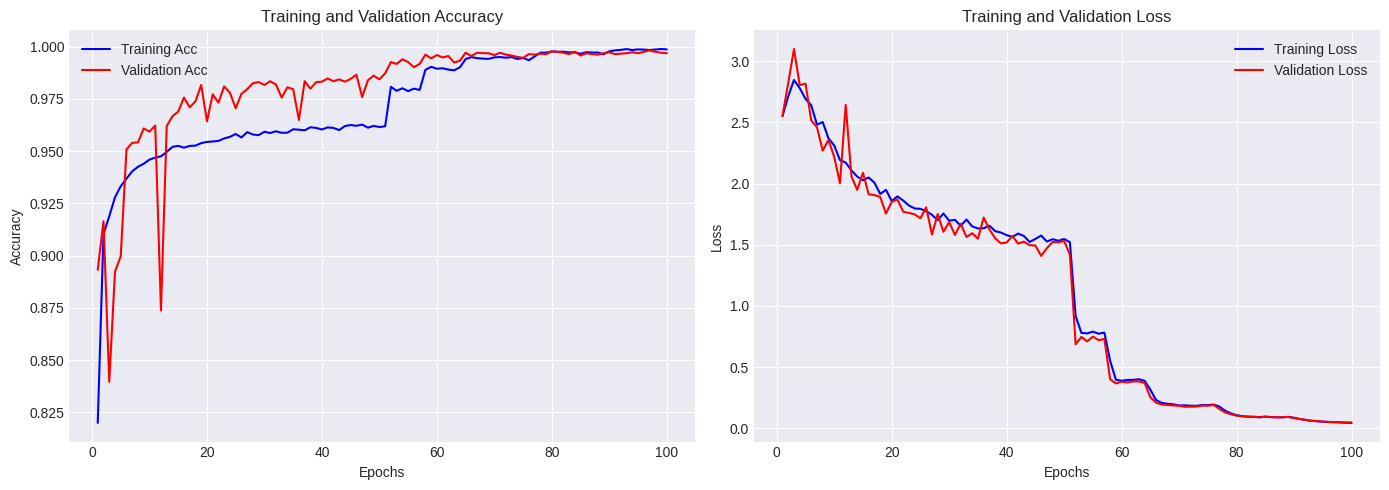

In [11]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [12]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

y_pred_prob = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

Test Accuracy: 80.80%
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

Classification Report:
                precision    recall  f1-score   support

       Abrupta       0.60      0.60      0.60         5
      Agaricus       0.75      0.60      0.67        10
  Alloclavaria       1.00      1.00      1.00        15
       Amanita       0.96      0.86      0.91        56
    Bisporella       0.74      0.91      0.82        22
       Boletus       1.00      0.92      0.96        24
   Chanterelle       0.59      0.76      0.67        34
 Chlorociboria       0.89      1.00      0.94        24
      Clathrus       0.71      0.86      0.77        14
     Cordyceps       0.91      0.80      0.85        49
   Cortinarius       0.80      0.75      0.77        16
       Cytidia       1.00      0.88      0.94        17
      Geastrum       0.83      0.83      0.83        12
    Gliophorus       0.67      0.43      0.52        14
     Gyromitra       0.78      1.00      0.88        14
      Helvella   

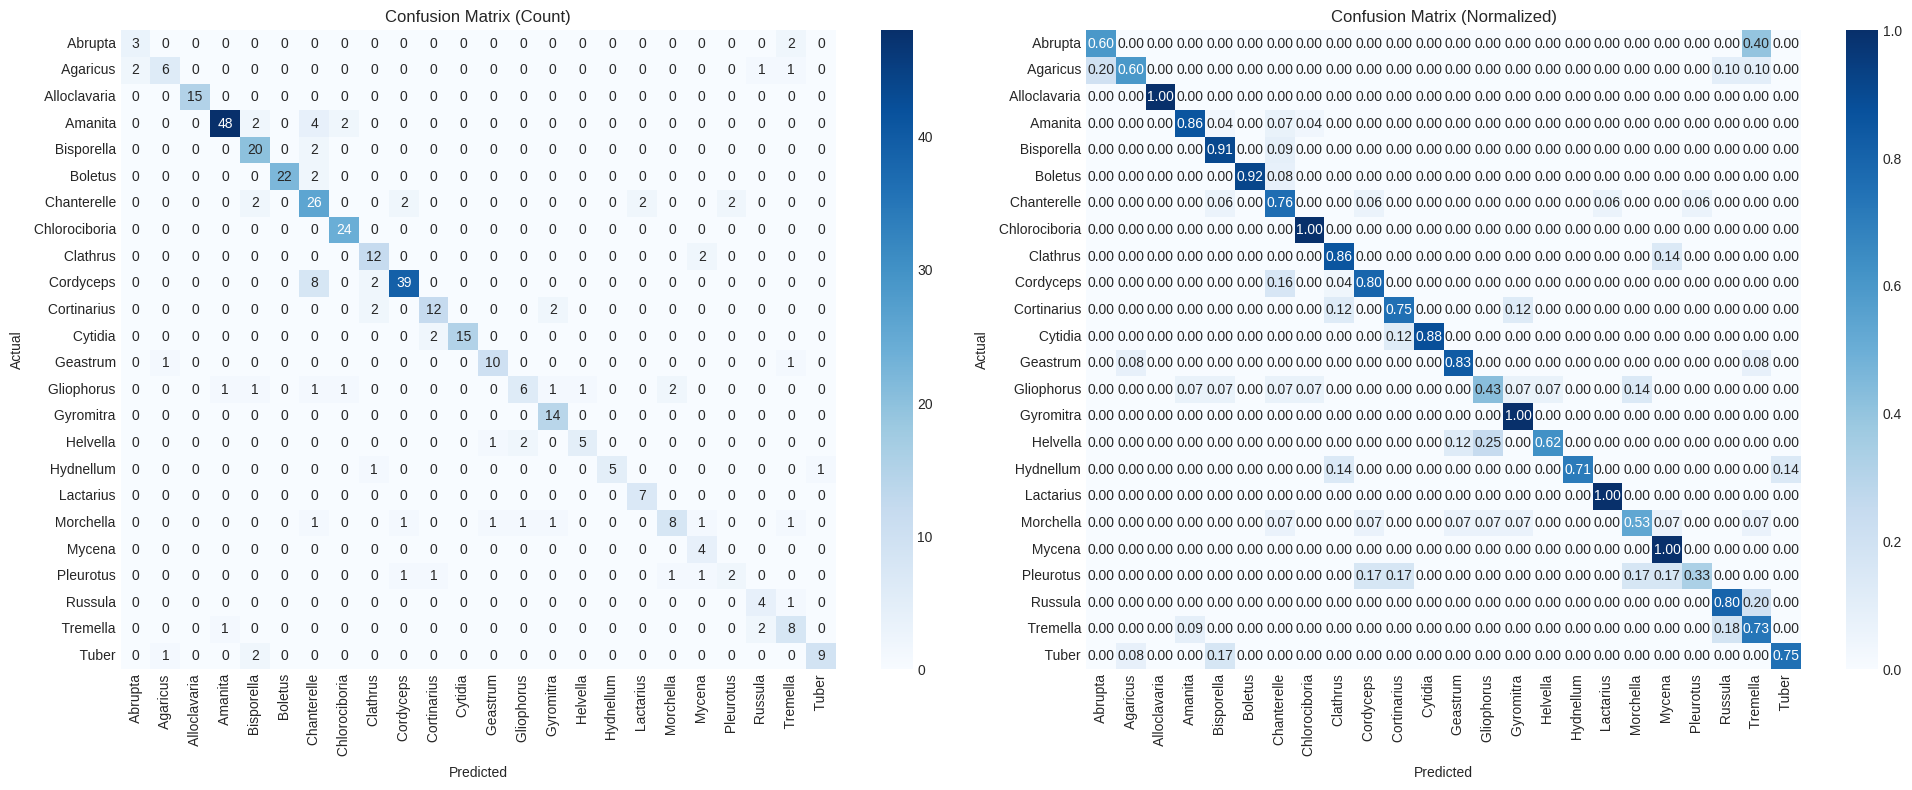

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Raw
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            ax=axes[0])
axes[0].set_title('Confusion Matrix (Count)')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

In [14]:
# Save Artifacts
joblib.dump(scaler, 'mushroom_scaler_2.joblib')
joblib.dump(le, 'mushroom_le_2.joblib')
print("Scaler and LabelEncoder saved.")

Scaler and LabelEncoder saved.
